# Simulación de un imán permanente

In [1]:
#Librerias
from numpy import *
from scipy import *
from scipy.special import *
from scipy.integrate import *
from pylab import *
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Lo que forma un imán es un campo de magnetización, $\vec{M}$, dentro de un material. Esto se puede pensar como muchos pequeños dipolos magnéticos alineados, creando así un campo magnético efectivo que es lo que se persibe en un imán permatente.

Acontinuación se hará la simulación de un imán con forma de circunferencia de un circulo para así poder recrear imanes con simetría cilindrica.

El campo magnético generado por un dipolo magnético, $\vec{\mu}$, colocado en $\vec{r}_{0}$ es:

$$ \vec{B} = \frac{\mu_{0}}{4\pi} \frac{3[\vec{\mu} \cdot (\vec{r}-\vec{r}_{0})] (\vec{r}-\vec{r}_{0}) - |\vec{r}-\vec{r}_{0}|^{2} \vec{\mu} }{|\vec{r}-\vec{r}_{0}|^{5}}$$

A continuación se pondrá todo en unidades de $\frac{\mu_{0}}{4\pi}$.

In [2]:
def campo_dipolar(mu, r_vec):
    #Todos los vectores vas a estar descritos en coordenadas cartesianas
    r = r_vec
    #Se define el producto punto entre el momento dipolar y la posición relativa r_vec-r_vec0
    mu_dot_r = mu[0]*r[0]+mu[1]*r[1]
    #Se define la norma de la posición relativa
    R = sqrt(r[0]**2+r[1]**2)
    
    Bx = (3*mu_dot_r*r[0] - (R**2) * mu[0])/R**5
    By = (3*mu_dot_r*r[1] - (R**2) * mu[1])/R**5
   
    return Bx, By

A continuación se grafica del campo magnético porducido por un dipolo en el origen orientado en el eje Z, $\mu = (0,1,0)$, en el plano XY.

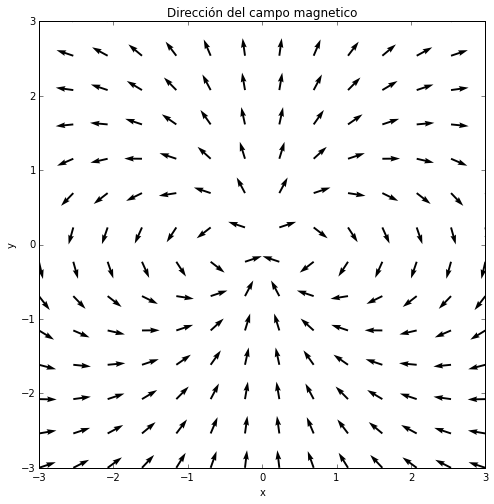

In [3]:
N_malla = 14
X_min, X_max, Y_min, Y_max = -3., 3., -3., 3.

x, y = linspace(X_min, X_max, N_malla), linspace(Y_min, Y_max, N_malla)
X, Y = meshgrid(x, y)

figure(figsize=(8,8),dpi=80)
Bx, By = campo_dipolar(array([0.,1.]), [X, Y])
B = sqrt(Bx**2+By**2)

quiver(X, Y, Bx/B, By/B)

gca().set_aspect('equal', adjustable='box')

xlabel('x') 
ylabel('y')
axis([X_min, X_max, Y_min, Y_max])
title(u'Dirección del campo magnetico')
show()

In [4]:
def campo_dipolar3D(dipolos, r_vec):
    #Todos los vectores vas a estar descritos en coordenadas cartesianas
    Bx, By, Bz = 0., 0., 0.
    for i in range(len(dipolos)):
        mui = dipolos[i][0]
        x = r_vec[0]-dipolos[i][1][0]
        y = r_vec[1]-dipolos[i][1][1]
        z = r_vec[2]-dipolos[i][1][2]
        
        #Se define el producto punto entre el momento dipolar y la posición relativa r_vec-r_vec0
        mu_dot_ri = mui[0]*x+mui[1]*y+mui[2]*z
        
        #Se define la norma de la posición relativa
        Ri = sqrt(x**2+y**2+z**2)

        Bx = Bx + ( 3*mu_dot_ri*x - (Ri**2) * mui[0] )/Ri**5
        By = By + ( 3*mu_dot_ri*y - (Ri**2) * mui[1] )/Ri**5
        Bz = Bz + ( 3*mu_dot_ri*z - (Ri**2) * mui[2] )/Ri**5
    
    return Bx, By, Bz

def dips_en_ciculo(radios, N, mu, z):
    Pos = []
    for i in range(len(radios)):
        for j in range(N[i]):
            x = radios[i]*cos(2*pi*j/N[i])
            y = radios[i]*sin(2*pi*j/N[i])
            
            Pos.append([mu[i], array([x, y, z[i]])])
    return Pos

Aquí ponemos la ecuación del movimiento de la partícula en el campo magnético:

La fuerza de Lorentz es la fuerza que se ejerce sobre una carga, su ecuación es:

$$\vec{F} = q(\vec{E} + \vec{v} \times \vec{B})$$

En este caso suponemos que no existe ningún campo eléctrico, por lo que la ecuación anterior resulta:

$$\vec{\dot{v}} = \frac{q}{m}\vec{v} \times \vec{B} = q_{m} \vec{v} \times \vec{B}$$

In [40]:
#Se define la ecuacion diferencial para resolver la dinamica de una particula
def carga_en_campo_xyz(entrada, t, ARGS):
    #cómo se llaman las entradas, primero introducimos la posición y luego la velocidad
    x,y,z,vx,vy,vz = entrada[0],entrada[1],entrada[2],entrada[3],entrada[4],entrada[5]

    #Se determinan los parametros necesarios para calcular el campo magnetico
    #un parametro adicional aparece, qm el cociente carga entre masa de la particula
    qm, dipolos = ARGS[0], ARGS[1]

    #Se determina el valor del campo mangetico
    Bx, By, Bz = campo_dipolar3D(dipolos, array([x, y, z]))
    
    #el producto punto entre la fuerza y el campo magnético
    vx_dot = (vy*Bz) - (vz*By)
    vy_dot = (vz*Bx) - (vx*Bz)
    vz_dot = (vx*By) - (vy*Bx)
    
    #la ecuación nos regresa velocidad inicial en x, y, z en ese orden y
    #fuerza en x, y, z
    return [vx,vy,vz, qm*vx_dot, qm*vy_dot, qm*vz_dot]

def dinamica(inicio, t_max, MallaT, qm, ARGS, flag = 0):
    #La variable ARGS tiene el siguiente formato ARGS = [radios, N_r, mu, z]
    #Se calculan cuales son los dipolos que hay 
    dipolos = dips_en_ciculo(ARGS[0], ARGS[1], ARGS[2], ARGS[3])
    
    #inicio es la condicion inicial de la particula
    #Se calcula el movimiento de la particula en el campo magnetico determinado por los parametros ARGS
    tiempo = linspace(0, t_max, MallaT)
    movimiento = odeint(carga_en_campo_xyz, inicio, tiempo, args = ([qm, dipolos],), 
                        rtol=1e-10, atol=1e-12, mxstep=int(1e6))

    x,y,z = movimiento[:, 0], movimiento[:, 1], movimiento[:, 2]        
    vx, vy, vz = movimiento[:, 3], movimiento[:, 4], movimiento[:, 5]
    
    
    fig = figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    ax.plot(x, y, z, label='Trayectoria de la carga')

    #Se pintan los dipolos como referencia
    X, Y, Z = [], [], []
    for i in range(len(dipolos)):
        X.append(dipolos[i][1][0])
        Y.append(dipolos[i][1][1])
        Z.append(dipolos[i][1][2])
    
    ax.scatter(X, Y, Z)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_aspect('equal', adjustable='box')
    ax.view_init(10,15)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    ax1.plot(x, y)
    ax1.set_xlabel ('Direccion X') 
    ax1.set_ylabel ('Direccion Y')
    ax1.set_title("Trayectoria en el plano XY")
    ax1.set_aspect('equal', adjustable='box')
    
    ax2.plot(tiempo, z)
    ax2.set_xlabel ('Tiempo') 
    ax2.set_ylabel ('Direccion Z')
    ax2.set_title("Z en funcion del tiempo")
    
    show()
    
    if flag == 1:
        return x, y, z, vx, vy, vz

In [41]:
def graf_campo(radios, N_r, z, mu, n):
    N_malla = 30j
    X_min, X_max, Y_min, Y_max, Z_min, Z_max = 0., 0., -n, n, 0.01, 7.
    X, Y, Z = np.mgrid[X_min:X_max:1j, Y_min:Y_max:N_malla, Z_min:Z_max:N_malla]
    fig = figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    ax1.axis([-n, n, 0., 7.])

    dipolos = dips_en_ciculo(radios, N_r, mu, z)

    Bx1, By1, Bz1 = campo_dipolar3D(dipolos, [X, Y, Z])
    B1 = sqrt(Bx1**2+By1**2+Bz1**2)

    bx1, by1, bz1 = Bx1/B1, By1/B1, Bz1/B1

    ax1.quiver(Y[0], Z[0], by1[0], bz1[0], log(B1[0]))
    show()

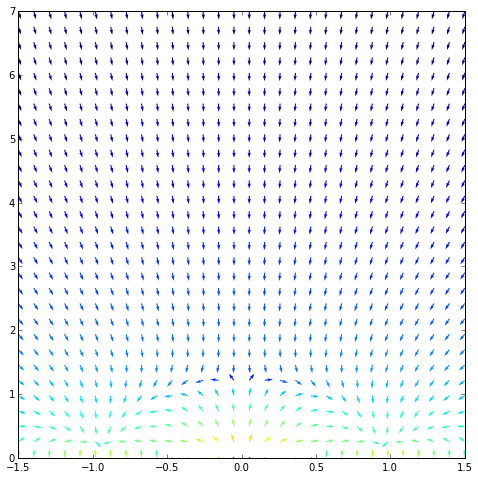

In [42]:
radios, N_r, z = [0., 1.], [1, 10], [0., 0.]
mu = [array([0., 0., 10.]), array([0., 0., -5.])]

graf_campo(radios, N_r, z, mu, 1.5)

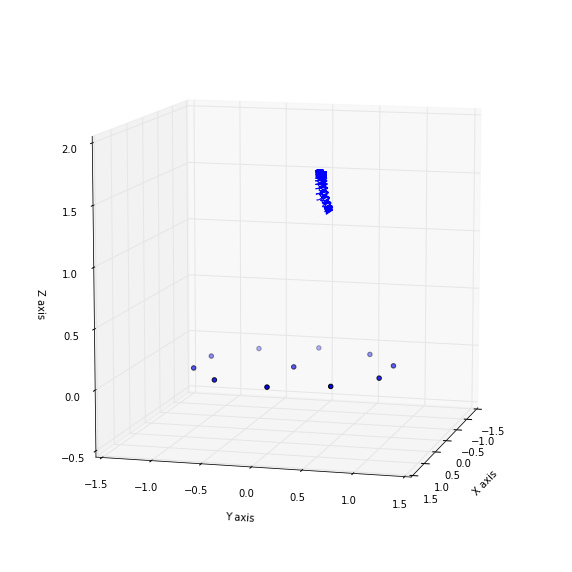

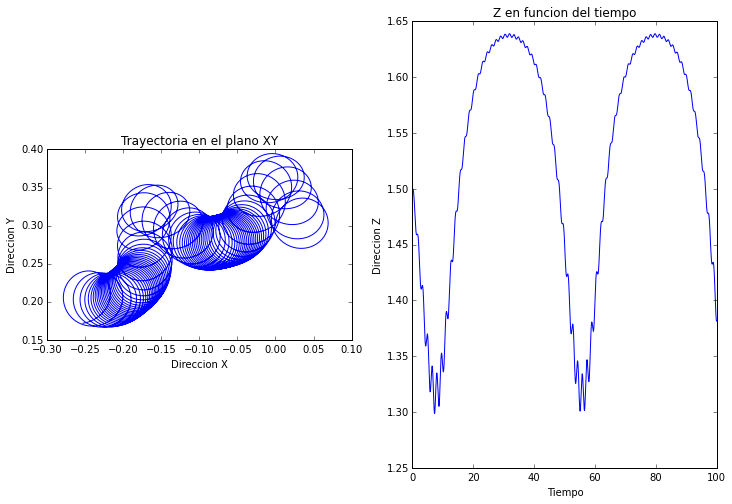

In [52]:
radios, N_r, z = [0., 1.], [1, 10], [0., 0.]
mu = [array([0., 0., 10.]), array([0., 0., -5])]
ARGS = [radios, N_r, mu, z]

T = 100.
X, Y, Z, VX, VY, VZ = dinamica([0., 0.3, 1.5,   0., 0.15, 0.], T, 2000.*T, -1., ARGS, 1)

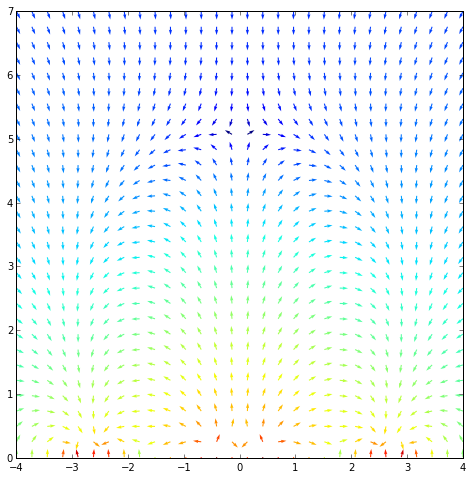

In [31]:
radios, N_r, z = [0.5, 1., 2.5, 3.], [10, 10, 50, 60], [0., 0., 0., 0.]
mu = [array([0., 0., 5.]), array([0., 0., 3.]), array([0., 0., -2.]), array([0., 0., -1.])]
graf_campo(radios, N_r, z, mu, 4.)

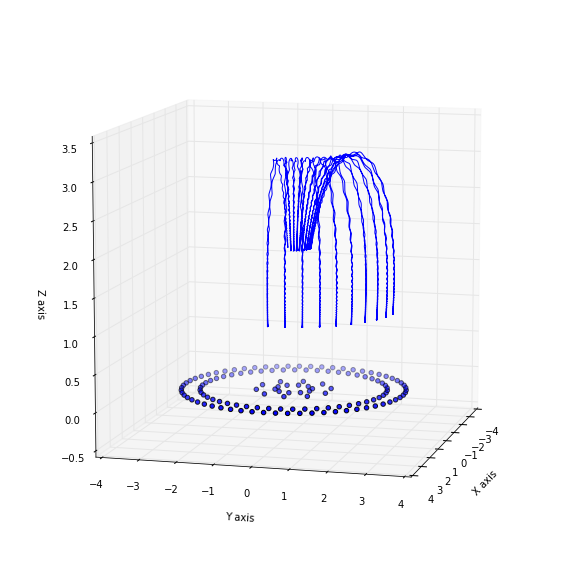

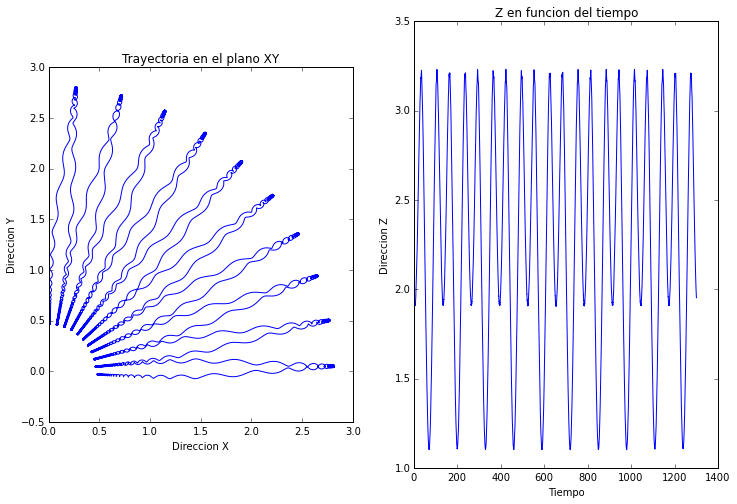

In [59]:
radios, N_r, z = [0.5, 1., 2.5, 3.], [10, 10, 50, 60], [0., 0., 0., 0.]
mu = [array([0., 0., 5.]), array([0., 0., 3.]), array([0., 0., -2.]), array([0., 0., -1.])]
ARGS = [radios, N_r, mu, z]

T = 5000.
X_, Y_, Z_, VX_, VY_, VZ_ = dinamica([0., 0.5, 2.,   0., -0.1, 0.], T, 2000.*T, -1., ARGS, 1)

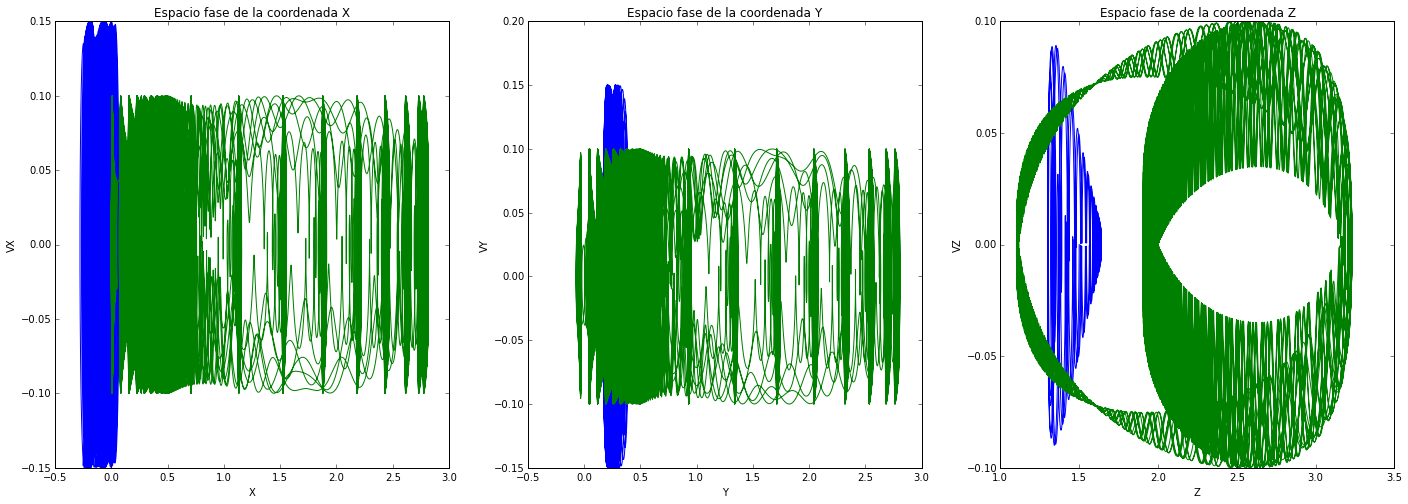

In [60]:
fig = figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(X, VX, X_, VX_)
ax2.plot(Y, VY, Y_, VY_)
ax3.plot(Z, VZ, Z_, VZ_)

ax1.set_xlabel("X")
ax1.set_ylabel("VX")
ax2.set_xlabel("Y")
ax2.set_ylabel("VY")
ax3.set_xlabel("Z")
ax3.set_ylabel("VZ")

ax1.set_title("Espacio fase de la coordenada X")
ax2.set_title("Espacio fase de la coordenada Y")
ax3.set_title("Espacio fase de la coordenada Z")